# Сегментация
В этот раз мы рассмотрим чуть менее стандартную задачу - сегментации изображений.


In [1]:
import math
import os
import warnings
from typing import Dict, List, Tuple

import albumentations as A
import cv2
import numpy as np
import random
import torch
import tqdm
import wandb
from PIL import Image
from torch import nn

import matplotlib.pyplot as plt
import torchmetrics
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import transforms
import albumentations.pytorch
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2


warnings.filterwarnings("ignore")

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kooaslansefat/uav-segmentation-aeroscapes")

100%|██████████| 753M/753M [05:04<00:00, 2.60MB/s] 

Extracting files...


In [8]:
base_dir = "C:/Users/draco/.cache/kagglehub/datasets/kooaslansefat/uav-segmentation-aeroscapes/versions/1/aeroscapes"
print(base_dir)
device = "cuda" if torch.cuda.is_available() else "cpu"

C:/Users/draco/.cache/kagglehub/datasets/kooaslansefat/uav-segmentation-aeroscapes/versions/1/aeroscapes


Для начала рассмотрим датасет изображений, полученных с дрона на высоте от 5 до 50 метров.

In [9]:
LABEL_NAMES = ['Background', 'Person', 'Bike', 'Car', 'Drone', 'Boat', 'Animal', 'Obstacle', 'Construction', 'Vegetation', 'Road', 'Sky']

COLOR_MAPPING = {
    (0, 0, 0): 0,  # Background
    (192, 128, 128): 1,      # Person
    (0, 128, 0): 2,          # Bike
    (128, 128, 128): 3,      # Car
    (128, 0, 0): 4,          # Drone
    (0, 0, 128): 5,          # Boat
    (192, 0, 128): 6,        # Animal
    (192, 0, 0): 7,          # Obstacle
    (192, 128, 0): 8,        # Construction
    (0, 64, 0): 9,           # Vegetation
    (128, 128, 0): 10,       # Road
    (0, 128, 128): 11,       # Sky
}


Сегментация - это та же классификация. Разница с обычным кейсом лишь в том, что классифицируется каждый пиксель изображенияю Поэтому вместо приятной структуры с папками нам придется вернуться к рукописным датасетам.

Создадим датасет: он будет читать файлы из папок с изображениями и масками. Маски трехмерные, но мы знаем их маппинг в классы. Так что легко можно поменять маску на номер желаемого класса. Остальное стандартно - трансформируем семпл, возвращаем результат.

Сейчас немного усложним задачу, будем читать из папки Visualizations, а не SegmentationMasks (но вы можете и оттуда сразу читать, конечно)

In [46]:
class AerialSegmentationDataset(Dataset):
    def __init__(self, root, data = "trn", transformations = None):
        files = open(f"{root}/ImageSets/{data}.txt", "r").read().split("\n")
        self.im_paths, self.gt_paths = self.get_data_paths(root = root, files = files) 
        self.transformations = transformations
        self.n_cls = 11
        assert len(self.im_paths) == len(self.gt_paths)
        
    def __len__(self): 
        return len(self.im_paths)

    def __getitem__(self, idx):
        im = self.read_image(self.im_paths[idx])
        mask = cv2.imread(self.gt_paths[idx], cv2.IMREAD_COLOR)
        mask = convert_mask(mask)
        if self.transformations: 
            transformed = self.transformations(image=im, mask=mask)
            im, mask = transformed["image"], transformed["mask"]
        return im, mask
        
    def get_data_paths(self, root, files) -> tuple[list[str], list[str]]:
        images = [
            path for path in sorted(glob(f"{root}/JPEGImages/*.jpg")) if self.get_fname(path) in files]
        masks = [
            path for path in sorted(glob(f"{root}/Visualizations/*.png")) if self.get_fname(path) in files]
        print(f"Found {len(images)} images and {len(masks)} masks.")
        return images, masks

       
    def get_fname(self, path): 
        return os.path.splitext(os.path.basename(path))[0]

    def read_image(self, path): 
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Convert to float32 and normalize
        image = image.astype(np.float32) / 255.0
        return image


def convert_mask(mask_rgb):
    mask = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype=np.uint8)
    for rgb, idx in COLOR_MAPPING.items():
        mask[(mask_rgb == rgb).all(axis=2)] = idx
    return mask
 

Создадим инстанс датасета для визуализации. 

In [47]:
im_h, im_w = 256, 256
transformations = A.Compose( [A.Resize(im_h, im_w),ToTensorV2(transpose_mask = True) ])

train_dataset = AerialSegmentationDataset(root=base_dir, data="trn", transformations=transformations)
test_dataset = AerialSegmentationDataset(root=base_dir, data="val", transformations=transformations)
n_cls = train_dataset.n_cls

Found 2621 images and 2621 masks.
Found 648 images and 648 masks.


Добавим функции для того, чтобы красиво нарисовать наши примеры

In [48]:
def plot(rows, cols, count, im, gt = None, title = "Original Image"):
    plt.subplot(rows, cols, count)
    image = im.squeeze(0).int().permute(1,2,0) if not gt else im.squeeze(0).float()
    plt.imshow(image)
    plt.axis("off"); plt.title(title)
    return count + 1
    
def visualize(ds, n_ims):
    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds)) for _ in range(n_ims)]
    for idx, index in enumerate(indices):
        if count == n_ims + 1: break
        im, gt = ds[index]
        # First Plot
        count = plot(rows, cols, count, im = im)
        # Second Plot
        count = plot(rows, cols, count, im = gt, gt = True, title="Segmentation mask")

И нарисуем

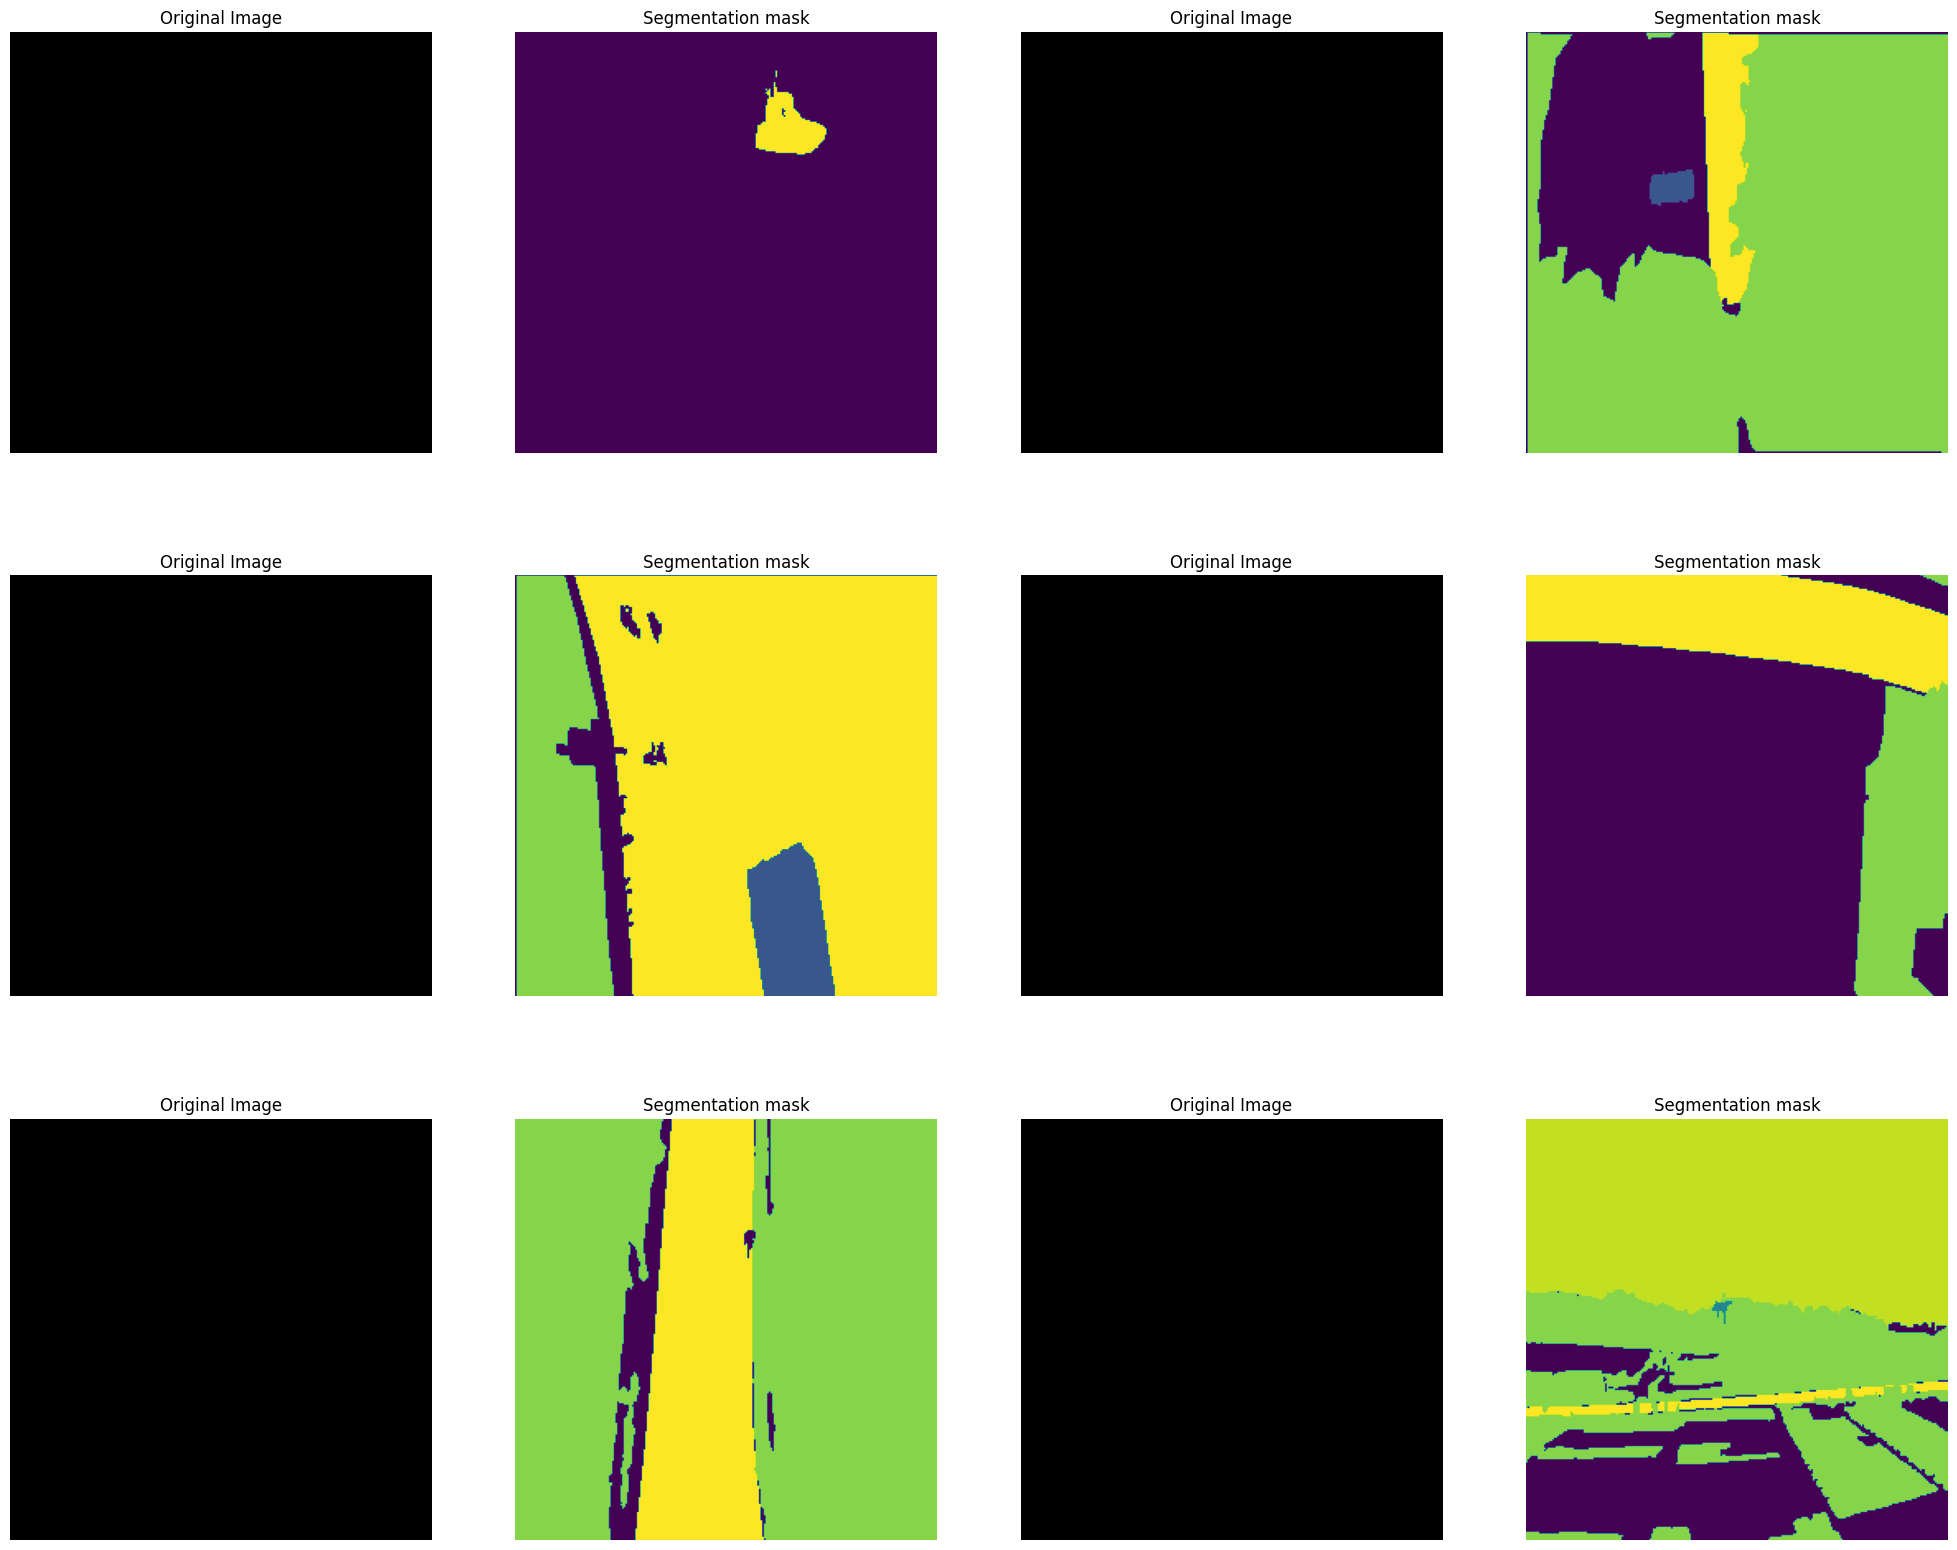

In [49]:
visualize(train_dataset, 12)

Дополнительное задание: выведите исходные пары изображение - трехканальная маска

Теперь уже создадим наш датасет, а также разобьем его на трейн-валидацию-тест

**Допзадание**: попробуйте еще другие аугментации

In [50]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
transformations = A.Compose([
    A.Resize(im_h, im_w),
    A.augmentations.transforms.Normalize(mean=mean, std=std), 
    ToTensorV2(transpose_mask=True)
])

split = [0.9, 0.1]
batch_size = 16

# Определение длины обучающей и валидационной выборок
total_len = len(train_dataset)
train_len = int(total_len * split[0])
val_len = total_len - train_len  # Остаток идет на валидацию

# Data split
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_len, val_len])

print(f"\nThere are {len(train_dataset)} number of images in the train set")
print(f"There are {len(val_dataset)} number of images in the validation set")
print(f"There are {len(test_dataset)} number of images in the test set\n")

# Get dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)



There are 2358 number of images in the train set
There are 263 number of images in the validation set
There are 648 number of images in the test set



Теперь создадим нашу архитектуру. Это [UNet](https://arxiv.org/pdf/1505.04597) - одна из базовых архитектур для сегментацию, аналоги которой еще и активно используются в самых разных приложениях.

Задание: дополните код, чтобы получить UNet с двумя внутренними блоками. 
Минимальная задача для слабых компьютеров - максимальное число фичей - 128. В таком случае мы будем использовать только по два блока, а не 4 исходных.

Исходная архитектура:
![alt_text](../additional_materials/images/u-net-architecture.png)

# Как реализовать up-conv?
В torch для этого есть nn.TransposeConv2d. 
На самом деле это не совсем свертка - она берет входные значения и вначале создает что-то вроде буфера, где хранит результаты умножения ядра на вход поэлементно. После того, как все результаты получены, они собираются воедино суммированием (можно посмотреть подробное объяснение [здесь](https://stackoverflow.com/questions/69782823/understanding-the-pytorch-implementation-of-conv2dtranspose):

![alt_text](../additional_materials/images/tc1.png)

Примеры:
![alt_text](../additional_materials/images/tc2.png)

![alt_text](../additional_materials/images/tc3.png)

![alt_text](../additional_materials/images/tc4.png)


In [51]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)

class UNet(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        out_channels: int = 1,
        features: List[int] = [32, 64, 128],
    ):
        super().__init__()
        self.down = nn.ModuleList()
        self.up = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling path
        for feature in features:
            self.down.append(ConvBlock(in_channels, feature))
            in_channels = feature
        
        # Bottleneck
        self.bottleneck = ConvBlock(features[-1], features[-1] * 2)

        # Upsampling path
        for feature in reversed(features):
            self.up.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.up.append(ConvBlock(feature * 2, feature))

        # Final convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        skip_connections = []
        
        # Downsampling
        for down in self.down:
            x = down(x)
            skip_connections.append(x)  # Store skip connections
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        
        # Upsampling
        skip_connections = skip_connections[::-1]  # Reverse skip connections
        for idx in range(0, len(self.up), 2):
            x = self.up[idx](x)  # Transpose convolution
            skip = skip_connections[idx // 2]  # Get the corresponding skip connection
            
            # If dimensions do not match, resize
            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
            
            concat_skip = torch.cat((skip, x), dim=1)  # Concatenate along channels
            x = self.up[idx + 1](concat_skip)  # Call the next ConvBlock
        
        return self.final_conv(x)


Создадим модель

In [52]:
model = UNet(out_channels=n_cls+1)

Теперь немного подушним с метриками. Для сегментации и детекции они похожи, так как обе задачи требуют определения целевых регионов. Поэтому наиболее естественны метрики, основанные на геометрии.
Рассмотрим две: IoU и Dice. 
![alt_text](../additional_materials/images/metrics.png)

Так как у нас задача мультиклассовая, мы должны посчитать эти метрики по классам и усреднить результат.

**Задание**: Дополните код, реализовав метрики mIoU и Dice.


Для того, чтобы можно было в будущем сочетать наши рукописные метрики и торчовые, напишем обертку, которая хранит в себе словарь со всем метриками сразу. Каждая рукописная должна иметь те же методы, что и torchmetrics.Metric: __call__ и compute()


In [53]:
from abc import ABC, abstractmethod
from typing import Iterable, Dict

class Metric(ABC):
    def __init__(self):
        self._values = []

    def __call__(self, preds: Iterable, targets: Iterable) -> float:
        value = self.compute_metric(preds, targets)
        self._values.append(value)
        return value

    @abstractmethod
    def compute_metric(self, preds: Iterable, targets: Iterable) -> float:
        pass

    def compute(self) -> float:
        if not self._values:
            return 0.0
        mean_value = sum(self._values) / len(self._values)
        return mean_value

    def reset(self):
        self._values = []

class MetricCollection:
    def __init__(self, metrics: Dict[str, Metric | torchmetrics.Metric]):
        if not isinstance(metrics, dict):
            raise TypeError("metrics must be a dictionary of Metric instances.")
        for name, metric in metrics.items():
            if not isinstance(metric, Metric) and not isinstance(metric, torchmetrics.Metric):
                raise TypeError(
                    f"Value for '{name}' is not an instance of Metric (handmade or torchmetrics)."
                )
        self.metrics = metrics

    def __call__(self, preds: Iterable, targets: Iterable) -> Dict[str, float]:
        computed_values = {}
        # Call metrics one by one
        for name, metric in self.metrics.items():
            computed_values[name] = metric(preds, targets)
        return computed_values

    def compute(self) -> Dict[str, float]:
        return {name: metric.compute() for name, metric in self.metrics.items()}

    def reset(self):
        for metric in self.metrics.values():
            metric.reset()


In [54]:
class MeanIntersectionOverUnion(Metric):
    def __init__(self, num_classes: int, eps: float = 1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.eps = eps

    def compute_metric(self, preds: torch.Tensor, targets: torch.Tensor) -> float:
        with torch.no_grad():
            # Convert predictions to class indices if they're in one-hot format
            if preds.dim() == targets.dim() + 1:
                preds = torch.argmax(preds, dim=1)

            iou_per_class = []
            for c in range(self.num_classes):
                # Get the true positive, false positive, and false negative for the class
                intersection = ((preds == c) & (targets == c)).sum().item()
                union = ((preds == c) | (targets == c)).sum().item()
                
                # Compute IoU and handle division by zero
                iou = intersection / (union + self.eps)
                iou_per_class.append(iou)

        return np.nanmean(iou_per_class)

class DiceScore(Metric):
    def __init__(self, num_classes: int, eps: float = 1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.eps = eps

    def compute_metric(self, preds: torch.Tensor, targets: torch.Tensor) -> float:
        # If preds are in one-hot format, convert them to class indices
        if preds.dim() == targets.dim() + 1:
            preds = torch.argmax(preds, dim=1)

        dice_per_class = []
        for c in range(self.num_classes):
            # Get the true positives, false positives, and false negatives for the class
            true_positives = ((preds == c) & (targets == c)).sum().item()
            predicted_positives = (preds == c).sum().item()
            actual_positives = (targets == c).sum().item()

            # Compute Dice score and handle division by zero
            dice = (2 * true_positives) / (predicted_positives + actual_positives + self.eps)
            dice_per_class.append(dice)

        return np.mean(dice_per_class)


Зададим лосс и оптимизатор. У нас еще задача не очень сложная, можем воспользоваться кросс-энтропией.

**Доп.задание**: создайте лосс из Dice Score. Обучите модель с новым лоссом. Как меняется результат? Объясните, почему можно сделать лосс из Dice Score, но не выйдет из IoU

In [55]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
            model.parameters(), lr=0.001, weight_decay=0.3
        )

In [56]:
metrics = MetricCollection({"mIoU": MeanIntersectionOverUnion(n_cls), "dice": DiceScore(n_cls)})

In [61]:
def train_epoch(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    metrics: MetricCollection,
    optimizer: torch.optim.Optimizer,
    binary: int | None = None,
    return_losses=False,
    device="cuda:0"  # Accept the device parameter
):
    model = model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []

    with tqdm.tqdm(total=len(data_loader)) as prbar:
        for inputs, targets in data_loader:
            # Move inputs and targets to the specified device
            inputs, targets = inputs.to(device), targets.to(device)
            
            targets = targets.long()
            
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            preds = model(inputs)

            # Compute the loss
            loss = criterion(preds, targets)

            # Backward pass
            loss.backward()

            # Optimization step
            optimizer.step()

            # Update metrics
            metrics_dict = metrics(preds, targets)

            # Prepare tqdm description
            metrics_desc = ",".join([f"{i}: {v:.4}" for i,v in metrics_dict.items()])
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} " + metrics_desc
            )
            prbar.update(1)

            # Accumulate loss and metrics
            total_loss += loss.item()
            num_batches += 1
            all_losses.append(loss.detach().item())

    # Compute and return metric values
    metric_values = metrics.compute()
    if return_losses:
        return metric_values, all_losses
    else:
        return metric_values


In [62]:
def validate(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    metrics: MetricCollection,
    binary: bool | None = None,
    device="cuda:0"  # Accept the device parameter
):
    model = model.eval()
    total_loss = 0
    num_batches = 0

    with tqdm.tqdm(total=len(data_loader)) as prbar:
        for inputs, targets in data_loader:
            # Move inputs and targets to the specified device
            inputs, targets = inputs.to(device), targets.to(device)
            
            with torch.no_grad():
                # Forward pass
                preds = model(inputs)
                
                # Compute the loss
                loss = criterion(preds, targets)
                
                # Update metrics
                metrics_val = metrics(preds, targets)

            # Prepare tqdm description
            metrics_desc = ",".join([f"{i}: {v:.4}" for i, v in metrics_val.items()])
            prbar.set_description(
                f"Loss: {loss.item():.4} " + metrics_desc
            )
            prbar.update(1)

            # Accumulate loss
            total_loss += loss.item()
            num_batches += 1

    # Return computed metrics and average loss
    avg_loss = total_loss / num_batches if num_batches > 0 else float('inf')
    return {**metrics.compute(), "loss": avg_loss}


In [63]:
def train(
    model: nn.Module,
    epochs: int,
    train_data_loader: torch.utils.data.DataLoader,
    validation_data_loader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    metrics: MetricCollection,
    optimizer: torch.optim.Optimizer,
    scheduler=None,
    binary: int | None = None,
    device="cuda:0",
    num_classes: int = 1
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []

    for epoch in range(epochs):
        # Train step
        print(f"Train Epoch: {epoch + 1}/{epochs}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            criterion=criterion,
            metrics=metrics,
            optimizer=optimizer,
            binary=binary,
            return_losses=True,
            device=device  # Pass the device to train_epoch
        )

        # Save train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])

        # Eval step
        print(f"Validation Epoch: {epoch + 1}/{epochs}")
        validation_metrics = validate(
            model=model,
            data_loader=validation_data_loader,
            criterion=criterion,
            metrics=metrics,
            binary=binary,
            device=device  # Pass the device to validate
        )

        # Save eval losses
        epoch_eval_losses.append(validation_metrics["loss"])

        # Scheduler step
        if scheduler:
            scheduler.step()

    return LossInfo(all_train_losses, epoch_train_losses, epoch_eval_losses)

In [65]:
model.to(device)

# Call the train function with the number of classes
_ = train(
    model=model,
    epochs=5,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    criterion=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    num_classes=n_cls
)

Train Epoch: 1/5


Loss: 0.9147 mIoU: 0.0968,dice: 0.1228:   2%|▏         | 3/148 [01:26<1:09:32, 28.78s/it]


KeyboardInterrupt: 

In [ ]:
def predict_img(
    net: nn.Module, img: torch.Tensor, device: str = device, out_threshold: float = 0.5
) -> np.ndarray:
    net.eval()
    net.to(device)

    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)
        probs = torch.softmax(output)
        full_mask = probs.cpu().squeeze()

        return (full_mask > out_threshold).numpy()

In [ ]:
image = test_dataset[0]
predict_img(model, image)

**Задание**: напишите функцию инференса и прогоните модель на тестовом датасете. Также используйте метрики, чтобы узнать точность в таком полубоевом режиме. Как именно организовать инференс - ваше решение 